# ADM-HW3: GROUP #14

#### Xavier Del Giudice, Alessio Iacono, Geraldine Maurer


| STUDENT |   ID    |                 E-mail                  |
| :-: |:-------:|:---------------------------------------:|
| Xavier Del Giudice | 1967219 | delgiudice.1967219@studenti.uniroma1.it |
| Alessio Iacono | 1870276 |   iacono.1870276@studenti.uniroma1.it   |
| Geraldine Maurer | 1996887 |           gmaurer0@gmail.com            |

## Import Packages 

In [1]:
%pip install unidecode geopy plotly dash aiofiles aiohttp nltk ipywidgets requests bs4 pandas


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import heapq
import nltk
import os
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from unidecode import unidecode
import string
import unicodedata
from IPython.display import display, clear_output
import aiohttp
import aiofiles
import pandas as pd
from collections import defaultdict
import pickle
import ipywidgets as ipw
from itertools import chain
from functions import utils, engine, crawler, parser

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xavie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xavie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\xavie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1. Data Collection

## 1.1. Get the list of Michelin restaurants

This script scrapes restaurant links from multiple pages of the Michelin guide website. 

In ```crawl_restaurant_links()``` function, it begins by sending a request to the first page and then parses the HTML content using BeautifulSoup. For each page, it searches for restaurant links, extracts them, and appends them to a list. The script then checks if there is a "next page" button and proceeds to the next page if available. The process continues until there are no more pages to scrape. 

Finally, all the extracted restaurant links are saved into a *.txt file* for later use.

In [3]:
# Initial url of the Michelin guide where to start scraping
base_url = 'https://guide.michelin.com/en/it/restaurants/page/'
# Pathname of .txt file where URLs will be stored
txt_out_pathname = 'michelin_restaurant_urls.txt'

# Start txt crawling
crawler.crawl_restaurant_links(base_url, txt_out_pathname)

Crawling completed. 1981 link saved in michelin_restaurant_urls.txt.


## 1.2. Crawl Michelin restaurant pages

This code **efficiently** downloads HTML pages using **asynchronous requests** and **concurrent processing** to maximize speed. 

It utilizes the aiohttp library to send multiple HTTP requests simultaneously, limiting the number of active connections to avoid overloading the server. The downloaded pages are saved into separate folders, with a new folder created every 20 pages, ensuring organized storage. 

**Asynchronous file operations** (***aiofiles***) are used to save the content, further enhancing performance. 

This approach significantly reduces the time needed to fetch multiple web pages compared to sequential downloading.

In [4]:
# Pathname of .txt file where URLs are stored
file_path = 'michelin_restaurant_urls.txt'
# Pathname of directory where HTML pages will be stored
output_dir = 'downloads'

async def main():
    # Load URLs from a file
    urls = await crawler.load_urls(file_path)
    # Download all URLs, organizing them into folders
    await crawler.download_all(urls, output_dir)

await main()

Download all the HTMLs of the URLs to their respective folders and files


## 1.3 Parse downloaded pages

This code extracts detailed restaurant information from a collection of downloaded HTML files. 

In ```utils.iterate_folders(output_dir)``` function, we iterate over each page folder and, using BeautifulSoup, the script parses each HTML file and retrieves the restaurant's name, address, city, postal code, country, price range, cuisine type, description, facilities, accepted credit cards, phone number, and website. 
The data is organized into a dictionary for each restaurant and stored in a list. 

Once all the HTML files are processed, the data is converted into a Pandas DataFrame and saved as a tab-separated .tsv file. The script helps in organizing structured restaurant data from raw HTML pages for further analysis.

In [5]:
# Directory containing the downloaded HTML files
output_dir = 'downloads'
# Pathname of .tsv where final dataset will be stored
tsv_pathname = 'restaurants_data.tsv'

# Create a pandas DataFrame from data scraped from HTML pages and then save it to .tsv file
df = pd.DataFrame(utils.iterate_folders(output_dir))
df.to_csv(tsv_pathname, sep='\t', index=False)

print(f"Data saved to {tsv_pathname}")

Data saved to restaurants_data.tsv


Convert NaN values in the dataset to empty strings (as required)  

In [2]:
# Read dataset from .tsv and convert NaN values to empty string
df = pd.read_csv('restaurants_data.tsv', sep='\t')
df = df.fillna("")

In [3]:
df.shape

(1981, 12)

We collected 12 differents info for 1981 restaurants, and stored it in a dataset!

In [8]:
df.head()

,restaurantName,city,postalCode,country,address,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website
0,20Tre,Genoa,16123,Italy,via David Chiossone 20 r,€€,"Farm to table, Modern Cuisine","Run by three partners, this contemporary-style...",['Air conditioning'],"['amex', 'dinersclub', 'mastercard', 'visa']",+39 010 247 6191,https://guide.michelin.com/en/liguria/genova/r...
1,Alessandro Feo,Marina di Casal Velino,84040,Italy,via Angelo Lista 24,€€,"Campanian, Seafood",In a beautiful stone-vaulted building (an old ...,[],"['amex', 'dinersclub', 'discover', 'maestrocar...",+39 328 893 7083,https://guide.michelin.com/en/campania/marina-...
2,Ape Vino e Cucina,Alba,12051,Italy,Piazza Risorgimento 3,€€,"Piedmontese, Contemporary",This attractive restaurant in the heart of Alb...,"['Air conditioning', 'Terrace', 'Wheelchair ac...","['amex', 'dinersclub', 'maestrocard', 'masterc...",+39 0173 363453,https://guide.michelin.com/en/piemonte/alba/re...
3,Charleston,Palermo,90141,Italy,via Generale Magliocco 19,€€€€,"Modern Cuisine, Creative","Before it became famous in Mondello, the renow...","['Air conditioning', 'Counter dining', 'Terrac...","['amex', 'mastercard', 'visa']",+39 091 450171,https://guide.michelin.com/en/sicilia/palermo/...
4,Da Bob Cook Fish,Sorrento,80067,Italy,largo Parsano vecchio 16,€€,Seafood,Working in partnership with the nearby fishmon...,"['Air conditioning', 'Terrace']","['amex', 'dinersclub', 'mastercard', 'visa']",+39 081 1778 3873,https://guide.michelin.com/en/campania/sorrent...


# 2. Search Engine

## 2.0 Preprocessing

In this exercise, we create and use two search engines, implemented in the ```engine.py``` file that can be found in the folder ```functions```. The first search engine accepts a query and returns all the restaurants whose description contains all the terms in the query. The second search engine computes the cosine similarity between a given query and all the restaurant descriptions, and returns the top k restaurants that match the query best

The first step is to preprocess the restaurant descriptions. For this, we use the custom-made function ```preprocessing```, and save all pre-processed documents in a list of documents ```preprocessed_docs```.

In [15]:
preprocessed_docs = defaultdict(list) # initialize defaultdict to store preprocessed docs
for doc_id, doc in enumerate(df.description):
  preprocessed_docs[doc_id] = engine.preprocessing(doc) # preprocess doc at position doc_id

Here is an example of what the preprocessed documents look like. They are now a list of tokens:

In [16]:
# Test description
text = '''After many years' experience in Michelin-starred restaurants, Luigi Tramontano and his wife Nicoletta
have opened their first restaurant in the chef's native Gargnano. Previously a pasta factory, the building has been converted
into an elegant, contemporary-style restaurant which has nonetheless retained its charming high ceilings.
The cuisine is inspired by regional traditions which are reinterpreted to create gourmet dishes,
all prepared with respect for the ingredients used and a strong focus on local produce.'''

# Test preprocessing on test description
print(engine.preprocessing(text))

['mani', 'year', 'experi', 'michelin', 'star', 'restaur', 'luigi', 'tramontano', 'wife', 'nicoletta', 'open', 'first', 'restaur', 'chef', 'nativ', 'gargnano', 'previous', 'pasta', 'factori', 'build', 'convert', 'eleg', 'contemporary', 'styl', 'restaur', 'nonetheless', 'retain', 'charm', 'high', 'ceil', 'cuisin', 'inspir', 'region', 'tradit', 'reinterpret', 'creat', 'gourmet', 'dish', 'prepar', 'respect', 'ingredi', 'use', 'strong', 'focu', 'local', 'produc']


## 2.1 Conjunctive Query

### 2.1.1 Create your Index!

After the preprocessing, we take these two steps: 
1. save unique tokens in a DataFrame ```vocabulary_df``` that maps terms to unique integer IDs
2. compute the inverted index for the documents. The inverted index is saved in a default dictionary, where the keys are the term IDs and the values are lists of document IDs of restaurant descriptions that contain the term. The code stores ```vocabulary_df``` in a csv file, and ```inverted_index``` in a pickle file.

In [17]:
# 1. Vocabulary File

# Retrieve the restaurants DataFrame
df = pd.read_csv('restaurants_data.tsv', sep='\t')

doc_tokens = [] # initialize list to store all tokens

# Find unique tokens
for doc in preprocessed_docs.values():
  doc_tokens.extend(doc)
  doc_tokens = list(set(doc_tokens)) # remove duplicates

vocabulary_dict = {term: i for i,term in enumerate(doc_tokens)} # dictionary of all vocabulary terms
vocabulary_df = pd.DataFrame({'term': vocabulary_dict.keys(), 'term_id': vocabulary_dict.values()}) # dataframe that maps terms to IDs

vocabulary_df.to_csv('vocabulary.csv', index=False) # save vocabulary dataframe in a csv file

In [18]:
# 2. Inverted Index

inverted_index = defaultdict(list) # initialize inverted_index dictionary

# Compute the inverted_index
for doc_id, row in enumerate(df.description):
  tokens = set(preprocessed_docs[doc_id]) # preprocessed description
  for token in tokens: # eliminate duplicates
    # Look up the term_id of the current term/token
    term_id = vocabulary_dict[token]
    # If the doc_id is not in the term_id's list in inverted_index, add it
    if doc_id not in inverted_index[term_id]:
      inverted_index[term_id].append(doc_id)

# Save the inverted_index dictionary to a file
with open("inverted_index.pkl", "wb") as file:
    pickle.dump(inverted_index, file)

Next, we allow the user to input a query. After clicking on search, the first search engine will be triggered to retrieve all restaurants that contain in their description the same terms as the query.

In [13]:
import ipywidgets as widgets
from IPython.display import display
# re-load inverted index in case it was modified somewhere
with open('inverted_index.pkl', 'rb') as file:
    inverted_index = pickle.load(file)

# Text input field for query
text_input = widgets.Text(
    value='',
    placeholder='Type your query',
    description='Query:',
    disabled=False
)

# Search button
search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='success'
)

output = widgets.Output()

# Define a function to handle button press
def on_search_button_clicked(b):
    with output:
        output.clear_output()  # clear previous output if there are any
        query = text_input.value
        if query.strip():  # Check if there's an input
            display(engine.find_restaurants(query, vocabulary_df, inverted_index, df)) # display query results
        else:
            print("Please enter something to search for.")

# Link the function to the button
search_button.on_click(on_search_button_clicked)

# Display the widgets
display(text_input, search_button, output)

Text(value='', description='Query:', placeholder='Type your query')

Button(button_style='success', description='Search', style=ButtonStyle())

Output()

In case the interactive search engine cannot be rendered, here is an example output for the query 'modern seasonal cuisine':

In case the interactive search engine cannot be rendered, here is an example output for the query 'modern seasonal cuisine':

In [16]:
# Example query
query = 'modern seasonal cuisine'

# Find restaurants with first search engine
display(engine.find_restaurants(query, vocabulary_df, inverted_index, df))

,restaurantName,address,description,website
0,20Tre,via David Chiossone 20 r,"Run by three partners, this contemporary-style...",https://guide.michelin.com/en/liguria/genova/r...
512,La Valle,via Umberto I 25 località Valle Sauglio,A well - run restaurant in a quiet area just o...,https://guide.michelin.com/en/piemonte/trofare...
899,San Giorgio,viale Brigate Bisagno 69r,Situated in the city albeit not right in the c...,https://guide.michelin.com/en/liguria/genova/r...
1797,Radimare,via Beato Piergiorgio Frassati 5/a,There’s no tasting menu at this restaurant but...,https://guide.michelin.com/en/puglia/monopoli/...
1158,Razzo,via Andrea Doria 17/f,"A quiet restaurant with a relaxed, young and m...",https://guide.michelin.com/en/piemonte/torino/...
903,Aprudia,largo del Forno 16,"At this restaurant in the historic centre, whe...",https://guide.michelin.com/en/abruzzo/giuliano...
1678,Retrobottega,via della Stelletta 4,Minimalist decor and clean lines characterise ...,https://guide.michelin.com/en/lazio/roma/resta...
143,Ca' Del Moro,località Erbin 31,Situated within the La Collina dei Ciliegi win...,https://guide.michelin.com/en/veneto/grezzana/...
1811,Locanda Solagna,piazza I Novembre 2,Although this restaurant has been in business ...,https://guide.michelin.com/en/veneto/quero/res...
277,San Michele,via Castello di Fagagna 33,Situated next to the ruins of the old castle a...,https://guide.michelin.com/en/friuli-venezia-g...


## 2.2 Ranked Search Engine with TF-IDF and Cosine Similarity

### 2.2.1 Inverted Index with TF-IDF Scores

In this exercise we implement the second search engine, and for that we first compute the inverted index with TF-IDF scores using the custom-made function ```tf_idf``` and save the ```updated_inverted_index``` in a pickle file. The function ```tf_idf``` computes the TF-IDF scores of a specific term for each preprocessed document, returning a list of tuples ```(doc_id, tf_idf)```.

In [17]:
# Preliminary steps
n = len(preprocessed_docs)
updated_inverted_index = defaultdict(list) # initialize default dictionary to store the inverted_index values with TF-IDF scores
inverted_index_copy = inverted_index.copy() # Create a copy of the inverted_index to iterate over

# Compute updated_inverted_index
for term_id, docs in inverted_index_copy.items():
  tf_idf_scores = engine.tf_idf(int(term_id), inverted_index, preprocessed_docs, vocabulary_df, n)
  updated_inverted_index[term_id] = list(zip(docs, tf_idf_scores))

with open('updated_inverted_index.pkl', 'wb') as file:
    pickle.dump(updated_inverted_index, file)

Next, we retrieve from ```updated_inverted_index``` the TF-IDF scores related to documents, and memorize only the tuples ```(term, tf-idf)``` where tf-idf $\neq 0$ for each document in a pickle file.

In [18]:
# Compute the TF-IDF vectors of all documents and store them in a pickle file
doc_tf_idf_scores = defaultdict(list) # initialize dictionary to store non-zero TF-IDF scores for each document

for term_id, docs_scores in updated_inverted_index.items():
  for doc_id, tf_idf_score in docs_scores:
    if tf_idf_score != 0:
      doc_tf_idf_scores[doc_id].append((term_id,tf_idf_score))
  doc_tf_idf_scores[doc_id].sort(key=lambda x: x[0]) # sort the terms

with open('doc_tf_idf_scores.pkl', 'wb') as file:
    pickle.dump(doc_tf_idf_scores, file)

Finally, we enable the user to input a text query, and return the top-k ranked restaurants by cosine similarity.

In [19]:
# re-load inverted index in case it was modified somewhere
with open('inverted_index.pkl', 'rb') as file:
    inverted_index = pickle.load(file)

# Text input field for query
text_input = widgets.Text(
    value='',
    placeholder='Type your query',
    description='Query:',
    disabled=False
)

# Search button
search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='success'
)

output = widgets.Output()

# Define a function to handle button press
def on_search_button_clicked(b):
    with output:
        output.clear_output()  # clear previous output if there are any
        query = text_input.value
        if query.strip():  # Check if there's an input
            k = 10
            display(engine.top_k_restaurants(query, inverted_index, vocabulary_dict, doc_tf_idf_scores, df, n, k)) # display query results
        else:
            print("Please enter something to search for.")

# Link the function to the button
search_button.on_click(on_search_button_clicked)

# Display the widgets
display(text_input, search_button, output)

Text(value='', description='Query:', placeholder='Type your query')

Button(button_style='success', description='Search', style=ButtonStyle())

Output()

In case the interactive search engine cannot be rendered, here is an example output prompted by the query 'modern seasonal cuisine':

In [20]:
# Example query
query = 'modern seasonal cuisine'

# Find restaurants with first search engine
display(engine.top_k_restaurants(query, inverted_index, vocabulary_dict, doc_tf_idf_scores, df, n, k=10))

,restaurantName,address,description,website,Similarity score
1650,La Botte,via Giuseppe Garibaldi 8,A modern and welcoming contemporary bistro sit...,https://guide.michelin.com/en/piemonte/stresa/...,0.228205
995,Piccolo Lord,corso San Maurizio 69 bis/g,"Professional service in a welcoming, modern re...",https://guide.michelin.com/en/piemonte/torino/...,0.206767
1001,Al Vecchio Convento,viale Borri 348,"Ask for a table in the main dining room, with ...",https://guide.michelin.com/en/lombardia/varese...,0.182369
1714,RistoFante,via Mazzini 41,The motto of this restaurant is “In step with ...,https://guide.michelin.com/en/lombardia/alzano...,0.170105
177,Saur,via Filippo Turati 8,"In a tiny rural village, this contemporary, al...",https://guide.michelin.com/en/lombardia/barco/...,0.166133
1024,Guallina,via Molino Faenza 19 località Guallina,Situated in a small house in an outlying villa...,https://guide.michelin.com/en/lombardia/mortar...,0.161213
1465,Barbieri,via Italo Barbieri,Enjoy your meal in the classic - style dining ...,https://guide.michelin.com/en/calabria/altomon...,0.160196
1579,Tre Scalini,via Sottile 23,The menu at this restaurant features meat and ...,https://guide.michelin.com/en/piemonte/novara/...,0.156441
1954,Mima,via Madonnelle 9,You’ll be won over by the seasonal Mediterrane...,https://guide.michelin.com/en/campania/vico-eq...,0.156309
1158,Razzo,via Andrea Doria 17/f,"A quiet restaurant with a relaxed, young and m...",https://guide.michelin.com/en/piemonte/torino/...,0.151769


# 3. Define a New Score!

A user interface(UI) is used to consider the user's additive information, which allows the user to enter the fields they prefer to find the restaurant.
We will use this additional information to predicate some of the rows in our dataset.
Since all restaurants are filtered by text initially, we want to give lower weight to the similarity between the description and the input query.  
Rather we want to give higher weight to user input details, which are the key to finding restaurants to which a user can bring interest.
For example, if I were to search for a restaurant and I have a particular desire to eat that cuisine I would want those as the first search results.
So we increase the score for the rows of the dataset for which we have a match for cuisine type.
We also increase multiplying a weight for the number of facilities and services matched with the input divided by the number of facilities the user inserted. And we increase the score if the price range is matched as well.
We can also find this behavior in very popular search engines, for example amazon search, prefers user-selected filters over the user's even detailed content in the search bar.

The results in the end turn out to be better, more accurate. We also have to consider that in the previous Engine based on the cosine similarity we are just considering the score based on the similarity between the input query and the description which is way larger than a possible query. Instead now we are building our own custom score where we give more importance to the details, in fact we have bigger score for the ones that perfectly fit the search. We are basically considering more fields so its obvious that the results are more accurated. But there is also to note that at the computational level this type of search is less performant since we have to initially load all the restaurants that respect the query input and then create a new score based on matching the user input and finally sort to select only the first k.

To perform this search, it was necessary to update the function ```find_restaurants``` in ```find_restaurants_updated```.
To allow all the columns to be used as well, considering also the usage of the following function in the map visualization.

Finally, the ```find_top_custom_restaurants``` function was created, available in the ```engine.py``` file. This return the DataFrame ordered by the new customScore just created.

Through the interface, users can interact with the application to obtain customized results based on their selections. Each time the "Search" button is clicked, a Pandas dataframe is returned with the requested data.

All inputs can be cleared using the "Clear" button. Users can specify several parameters, including:

- Text to input for the search
- Cuisine type
- Desired facilities and services
- Price range
- Number of results to display  

For each search, a ```top_k_result.tsv``` file is generated, allowing the main results to be saved and used for map visualization. These features are designed to work seamlessly together, ensuring a smooth and efficient user experience.

In [19]:
from functions.search_restaurant_ui import SearchRestaurantUI

In [21]:
search_ui = SearchRestaurantUI(df, vocabulary_df, inverted_index)
search_ui.display()

As the previous points, we can not visualize the UI just created.
But if you would like to use it, you can download the code and run it in local.
In the next cell you will see the output generated by the parameters:  

**Description searched** : modern seasonal cuisine  

**Cuisine Type** : Italian Contemporary, Creative  

**Facilities & Services** : Air Conditioning, Car Park, Interesting Wine List  

**Price Range** : €€€

**Number of Results** : 10 

In [22]:
# Example query
query = {
    'description' : 'modern seasonal cuisine',
    'cuisineType' : 'Italian Contemporary, Creative',
    'facilitiesServices' : ['Air conditioning', 'Car park', 'Interesting wine list'],
    'priceRange' : '€€€',
    'num_results' : 10
}

# Find restaurants with first search engine
display(engine.find_top_custom_restaurants(query, vocabulary_df, inverted_index, df))

,restaurantName,address,description,website,customScore
1524,Cappuccini Cucina San Francesco,via Cappuccini 54,"Housed in the resort of the same name, this el...",https://guide.michelin.com/en/lombardia/cologn...,0.901495
791,La Bandiera,contrada Pastini 4,Although it takes a while to reach this restau...,https://guide.michelin.com/en/abruzzo/civitell...,0.600951
1909,Il Tino,via Monte Cadria 127,Enjoying an attractive location in the Nautilu...,https://guide.michelin.com/en/lazio/fiumicino/...,0.600000
512,La Valle,via Umberto I 25 località Valle Sauglio,A well - run restaurant in a quiet area just o...,https://guide.michelin.com/en/piemonte/trofare...,0.502010
143,Ca' Del Moro,località Erbin 31,Situated within the La Collina dei Ciliegi win...,https://guide.michelin.com/en/veneto/grezzana/...,0.501760
1598,Sintesi,viale dei Castani 17,"A modern, welcoming restaurant whose motto “Tr...",https://guide.michelin.com/en/lazio/ariccia/re...,0.501354
899,San Giorgio,viale Brigate Bisagno 69r,Situated in the city albeit not right in the c...,https://guide.michelin.com/en/liguria/genova/r...,0.500789
1714,RistoFante,via Mazzini 41,The motto of this restaurant is “In step with ...,https://guide.michelin.com/en/lombardia/alzano...,0.402797
903,Aprudia,largo del Forno 16,"At this restaurant in the historic centre, whe...",https://guide.michelin.com/en/abruzzo/giuliano...,0.401874
1501,[àbitat],via Henry Dunant 1,"A young, enthusiastic and professional couple ...",https://guide.michelin.com/en/lombardia/san-fe...,0.401737


# 4. Visualizing the Most Relevant Restaurants

## 4.1 Geocode Locations

This script extracts restaurant information from the directory *downloads*, where each restaurant HTML page is stored, processes it, and saves the data in a tabular format (TSV). 

Here's a breakdown of its functionality:

- **Restaurant Data Extraction**: ```utils.iterate_geo_folders(output_dir) ```

    Uses **BeautifulSoup** to parse each .html file, then locates and processes a JSON script tag within the HTML to extract specific restaurant information, including:
    - Name (*restaurantName*)
    - Region (*addressRegion*)
    - Latitude (*latitude*)
    - Longitude (*longitude*) 
    
- **Region Translation** ``` utils.translateRegions() ``` :
    Since some regions have their names in English, we map and replace them with their Italian equivalents using a predefined dictionary.

- **Data Storage**:
    Compiles the extracted data into a list of dictionaries and convert this list into a Pandas DataFrame.
- **Data Export**:
    Saves the processed restaurant data to a file named geodata.tsv in tabular format (TSV).

In [23]:
# Directory where .html files are stored
output_dir = 'downloads'
# Filename of tsv where geodata (region, latitude and longitude) of each restaurant will be saved
tsv_filename = 'geodata.tsv'

# Create a pandas DataFrame from scraped geodata
df = pd.DataFrame(utils.iterate_geo_folders(output_dir))

# Translation of italian region from english to italian name (needed for map)
df['region'] = utils.translateRegions(df['region'])

# Save the data to a CSV file
df.to_csv(tsv_filename, sep='\t', index=False)
print(f"Data saved to {tsv_filename}")

Data saved to geodata.tsv


To merge the information about the restaurants and their geo-localition info we need to merge the two different table: ```restaurants_data.tsv``` and ```geodata.tsv```. </br>
To do this we use pandas command: ```merge```, but first, to avoid duplicates and bias we defined an attribute of join. </br>
It need to be unique for each row of the two dataset. So we defined *restaurantId* that is an autoincrement value for each row of the dataset (primarey key).
We also sort all rows of the two datasets by *restaurant name* to have a perfect match within the restaurant.

In [24]:
# Retrieve restaurants_data.tsv dataframe
df = pd.read_csv('restaurants_data.tsv', sep='\t')

# Sort DF by 'restaurantName' column
df = df.sort_values(by="restaurantName")

# Assign numerical and sequential restaurantId to each restaurant 
df['restaurantId'] = range(1, len(df) + 1)

We repeat the creation of the *restaurantId* column for the ```geodata.tsv```

In [25]:
# Retrieve geodata.tsv dataframe
df_geo = pd.read_csv("geodata.tsv", sep='\t')

# Sort DF by 'restaurantName' column
df_geo = df_geo.sort_values(by="restaurantName")

# Assign numerical and sequential restaurantId to each restaurant 
df_geo['restaurantId'] = range(1, len(df) + 1)

print(df_geo.shape)
df_geo.head()

(1981, 5)


,restaurantName,region,latitude,longitude,restaurantId
1966,/gu.stà.re/ oltrecucina,Piemonte,45.698461,8.465723,1
1920,12 Ristorante,Emilia-Romagna,44.198365,12.393893,2
500,13 Comuni,Veneto,45.605300,11.095870,3
100,177 toledo,Campania,40.840693,14.248738,4
1360,1908,Trentino-Alto Adige/Südtirol,46.528256,11.405296,5


Now we can merge this two table, on the specified attribute (*restaurantId*), obtaining a new pandas DataFrame. 

In [26]:
# Merge dataframes, matching rows by 'restaurantID' (present in both DF).
df_final = pd.merge(df, df_geo, on='restaurantId', how='right')

print(df_final.shape)
df_final.head()

(1981, 17)


,restaurantName_x,city,postalCode,country,address,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website,restaurantId,restaurantName_y,region,latitude,longitude
0,/gu.stà.re/ oltrecucina,Borgomanero,28021,Italy,via Antonio Gramsci 20/b,€€,Modern Cuisine,An attractive contemporary-style restaurant ri...,"['Air conditioning', 'Wheelchair access']","['amex', 'maestrocard', 'mastercard', 'visa']",+39 345 977 8016,https://guide.michelin.com/en/piemonte/borgoma...,1,/gu.stà.re/ oltrecucina,Piemonte,45.698461,8.465723
1,12 Ristorante,Cesenatico,47042,Italy,via Armellini 12/a,€€,Seafood,"An original ambience with real character, as w...","['Air conditioning', 'Terrace']","['amex', 'dinersclub', 'maestrocard', 'masterc...",+39 0547 82093,https://guide.michelin.com/en/emilia-romagna/c...,2,12 Ristorante,Emilia-Romagna,44.198365,12.393893
2,13 Comuni,Velo Veronese,37030,Italy,piazza della Vittoria 31,€€,"Venetian, Seasonal Cuisine","Situated in the village square, this restauran...",['Terrace'],"['mastercard', 'visa']",+39 045 783 5566,https://guide.michelin.com/en/veneto/velo-vero...,3,13 Comuni,Veneto,45.605300,11.095870
3,177 toledo,Naples,80134,Italy,via Toledo 177,€€€€,"Italian Contemporary, Creative","On the fifth floor of 177, via Toledo this res...",['Air conditioning'],"['amex', 'unionpay', 'dinersclub', 'discover',...",+39 081 1818 1380,https://guide.michelin.com/en/campania/napoli/...,4,177 toledo,Campania,40.840693,14.248738
4,1908,Soprabolzano,39054,Italy,via Paese 18,€€€€,"Creative, Contemporary",The name of this restaurant refers to the year...,"['Car park', 'Interesting wine list']","['amex', 'mastercard', 'visa']",+39 0471 345232,https://guide.michelin.com/en/trentino-alto-ad...,5,1908,Trentino-Alto Adige/Südtirol,46.528256,11.405296


As we can see from the output above the column restaurantName seems to be not unique, that's way we didn't use this column as attribute of join.
This is probably caused by the data gathering process, in which is possibile that some character differs from the two tables.
So, we decided to check how many rows differs in the relative column, then we drop one of the two and we keep it as "restaurantName".

In [27]:
df_final = df_final.rename(columns={'restaurantName_x': 'restaurantName'})

# Drop column 'restaurantName_y'
df_final = df_final.drop(columns=['restaurantName_y'])

print(df_final.shape)
df_final.head()

(1981, 16)


,restaurantName,city,postalCode,country,address,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website,restaurantId,region,latitude,longitude
0,/gu.stà.re/ oltrecucina,Borgomanero,28021,Italy,via Antonio Gramsci 20/b,€€,Modern Cuisine,An attractive contemporary-style restaurant ri...,"['Air conditioning', 'Wheelchair access']","['amex', 'maestrocard', 'mastercard', 'visa']",+39 345 977 8016,https://guide.michelin.com/en/piemonte/borgoma...,1,Piemonte,45.698461,8.465723
1,12 Ristorante,Cesenatico,47042,Italy,via Armellini 12/a,€€,Seafood,"An original ambience with real character, as w...","['Air conditioning', 'Terrace']","['amex', 'dinersclub', 'maestrocard', 'masterc...",+39 0547 82093,https://guide.michelin.com/en/emilia-romagna/c...,2,Emilia-Romagna,44.198365,12.393893
2,13 Comuni,Velo Veronese,37030,Italy,piazza della Vittoria 31,€€,"Venetian, Seasonal Cuisine","Situated in the village square, this restauran...",['Terrace'],"['mastercard', 'visa']",+39 045 783 5566,https://guide.michelin.com/en/veneto/velo-vero...,3,Veneto,45.605300,11.095870
3,177 toledo,Naples,80134,Italy,via Toledo 177,€€€€,"Italian Contemporary, Creative","On the fifth floor of 177, via Toledo this res...",['Air conditioning'],"['amex', 'unionpay', 'dinersclub', 'discover',...",+39 081 1818 1380,https://guide.michelin.com/en/campania/napoli/...,4,Campania,40.840693,14.248738
4,1908,Soprabolzano,39054,Italy,via Paese 18,€€€€,"Creative, Contemporary",The name of this restaurant refers to the year...,"['Car park', 'Interesting wine list']","['amex', 'mastercard', 'visa']",+39 0471 345232,https://guide.michelin.com/en/trentino-alto-ad...,5,Trentino-Alto Adige/Südtirol,46.528256,11.405296


Now we can see how is our ```df_final``` composed. We have all the information about the restaurant and we also added the information about its region and latidute and longitude.
This allow us to represent the restaurant and all its information as point in our map plot.

## 4.3 Map Setup

**Python Dash web application** designed to display and interact with restaurant data on maps of Italy and its regions. <br>

Here's a summary:

- ***Purpose***: <br>
    The app shows a choropleth map of Italian regions (left) and allows users to click on a region to view detailed restaurant information on a zoomed-in map (right). <br>
    Users can optionally filter restaurants to show only "Top-K" entries from a pre-defined dataset in ***Point 3*** (*top_k_result.tsv*).

- ***Key Features***: <br>
    The left map (*Italy map*) displays all regions and allows selecting a region via clicks.<br>
    The right map (*Region map*) shows restaurants located in the selected region, categorized by price range and marked with color-coded pins.<br>
    Hovering over restaurant markers reveals details such as name, city, address, and cuisine type.

- ***Data Handling***: <br>
    The app uses GeoPandas for loading a GeoJSON file of Italian regions and ensures it has the proper CRS (EPSG:4326) for accurate centroid calculations, so that Region map is always displayed centered<br>
    Restaurant data is filtered based on user input (e.g., Top-K filter or region selection).

- ***Interactive Components***: <br>
    A checklist allows toggling the "Top-K" filter. <br>
    Maps are updated dynamically using Dash callbacks based on user interactions like region clicks or checkbox toggles.

    **N.B.** *If we change parameters for which scores are calculated, so if our "Top-k" restaurants changes, just toggle two times to the "Show Top-K" checkbox to update the map*

    <br>

- ***Visualizations***: <br>
    Built using Plotly’s choropleth_mapbox for choropleth maps and scattermapbox for restaurant markers.

- ***Technical Notes***: <br>
    The application operates as a standalone Dash server and can be used either in a Jupyter Notebook or rendered in an external web browser.
    
    To control where the map is displayed, modify the last line of code in the cell accordingly:
    
    - **External Browser (DEFAULT)**
        ``` python
        app.run_server(jupyter_mode='external', debug=True)
        ```
    - **Jupyter Notebook**
        ``` python
        app.run_server(debug=True)
        ```

In [28]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import geopandas as gpd
import pandas as pd
import json

# Load GeoJSON file of Italian regions; necessary to draw region borders on the Italy map
gdf = gpd.read_file("./GeoJson/limits_IT_regions.geojson")

# Update the "Coordinate Reference System" (CRS) of the GeoDataFrame
# This ensures that the centroids of the regions are calculated correctly
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Extract the list of region names from the GeoDataFrame
region_names = gdf['reg_name'].tolist()

# Create the Dash app instance (Dash provides an API for creating web apps in Python)
app = dash.Dash(__name__)

# Define the app layout, which includes filters and maps
app.layout = html.Div([
    html.Div([
        # Add a checklist for filtering Top-K restaurants
        dcc.Checklist(
            id='show-top-k',
            options=[{'label': 'Show Top-K Restaurants Only', 'value': 'top_k'}],
            value=[],
            inline=True
        ),
    ]),
    
    # Create two maps: 
    # 1. An Italy map (left) where the user can click on a region.
    # 2. A detailed region map (right) showing restaurants in the selected region.
    html.Div([
        dcc.Graph(id='italy-map', clickData=None, style={'width': '50vw', 'height': '100vh'}),
        dcc.Graph(id='region-map', style={'width': '50vw', 'height': '100vh'})
    ], style={'display': 'flex', 'flex-direction': 'row'})
])

# Initialize a global variable to store filtered restaurant data
filtered_restaurants = df_final

# Define a callback to update both maps based on user interaction
@app.callback(
    [Output('italy-map', 'figure'),
     Output('region-map', 'figure')],
    [Input('italy-map', 'clickData'),
     Input('show-top-k', 'value')]
)
# Function to update maps:
# - The left map (Italy) allows selecting a region.
# - Clicking on a region updates the right map with detailed restaurant information.
def update_maps(clickData, show_top_k):
    global filtered_restaurants
    
    # Filter restaurants if the "Top-K" checkbox is checked
    if 'top_k' in show_top_k:
        top_k_df = pd.read_csv('top_k_result.tsv', sep='\t')
        filtered_restaurants = df_final[df_final['restaurantName'].isin(top_k_df['restaurantName'])]
    else:
        filtered_restaurants = df_final

    # Variable to track the currently selected region
    selected_region = None
    if clickData:
        selected_region = clickData['points'][0]['location']

    # Create the Italy map
    italy_map = px.choropleth_mapbox(
        geojson=json.loads(gdf.to_json()),  # Use the GeoJSON for regions
        locations=gdf['reg_name'],         # Match regions using the "reg_name" column
        featureidkey="properties.reg_name",
        color_continuous_scale=['grey'],   # Light grey color for regions
        opacity=0.2,                       # Semi-transparent regions
        mapbox_style="carto-positron",     # Map styling
        zoom=4.5,                          # Default zoom level for Italy
        center={"lat": 41.8719, "lon": 12.5674},  # Center of Italy
        title="Map of the Italian Regions" # Map title
    )
    
    # Add restaurant markers to the Italy map if "Top-K" is enabled and a region is selected
    if 'top_k' in show_top_k and selected_region:
        for price_range, color in [('€', 'teal'), ('€€', 'red'), ('€€€', 'mediumpurple'), ('€€€€', 'peru')]:
            # Filter restaurants by price range
            price_restaurants = filtered_restaurants[filtered_restaurants['priceRange'] == price_range].copy()

            # Generate hover info for each restaurant
            priceBox = price_restaurants.apply(
                lambda row: (
                    f"<b>Name:</b> {row['restaurantName']}<br>"
                    f"<b>City:</b> {row['city']}<br>"
                    f"<b>Address:</b> {row['address']}<br>"
                    f"<b>Types of cuisine: </b> {row['cuisineType']}<br>"
                ), axis=1)
            price_restaurants['hover_info'] = priceBox if not priceBox.empty else None

            # Add restaurant markers to the Italy map
            italy_map.add_scattermapbox(
                lat=price_restaurants['latitude'].tolist(),
                lon=price_restaurants['longitude'].tolist(),
                mode='markers',
                marker=dict(size=10, color=color, opacity=0.8),
                text=price_restaurants['restaurantName'],
                name=price_range,
                hoverlabel=dict(
                    bgcolor="whitesmoke", 
                    bordercolor=color, 
                    font=dict(
                        color=color
                    )
                ),
                hovertemplate="%{customdata[0]}",
                customdata=price_restaurants[['hover_info']].values
            )
    
    # Highlight the selected region with a red border (NOT WORKING)
    # if selected_region:
    #     italy_map.update_traces(marker_line_color="red", selector=dict(location=selected_region))
    
    # Generate a map for the selected region
    if selected_region:
        region_gdf = gdf[gdf['reg_name'] == selected_region]
        
        # Calculate the centroid of the region for map centering
        region_gdf_proj = region_gdf.to_crs(epsg=32632)
        centroid_proj = region_gdf_proj.geometry.centroid.iloc[0]
        centroid = gpd.GeoSeries([centroid_proj], crs="EPSG:32632").to_crs("EPSG:4326").iloc[0]
        center_lat, center_lon = centroid.y, centroid.x

        # Filter restaurants in the selected region
        filtered_restaurants_region = filtered_restaurants[filtered_restaurants['region'] == selected_region]

        # Create the region map
        region_map = px.choropleth_mapbox(
            geojson=json.loads(region_gdf.to_json()),  # GeoJSON for the selected region
            locations=[selected_region],
            featureidkey="properties.reg_name",
            mapbox_style="carto-positron",
            color_discrete_sequence=['red'],  # Red for the selected region
            opacity=0.1,
            zoom=6,
            center={"lat": center_lat, "lon": center_lon},
            title=f"Map of {selected_region} with Restaurants"  # Region map title
        )
        
        # Add restaurant markers for the selected region
        for price_range, color in [('€', 'teal'), ('€€', 'red'), ('€€€', 'mediumpurple'), ('€€€€', 'peru')]:
            price_restaurants = filtered_restaurants_region[filtered_restaurants_region['priceRange'] == price_range].copy()

            priceBox = price_restaurants.apply(
                lambda row: (
                    f"<b>Name:</b> {row['restaurantName']}<br>"
                    f"<b>City:</b> {row['city']}<br>"
                    f"<b>Address:</b> {row['address']}<br>"
                    f"<b>Types of cuisine: </b> {row['cuisineType']}<br>"
                ), axis=1)
            price_restaurants['hover_info'] = priceBox if not priceBox.empty else None

            region_map.add_scattermapbox(
                lat=price_restaurants['latitude'].tolist(),
                lon=price_restaurants['longitude'].tolist(),
                mode='markers',
                marker=dict(size=10, color=color, opacity=0.8),
                text=price_restaurants['restaurantName'],
                name=price_range,
                hoverlabel=dict(
                    bgcolor="whitesmoke", 
                    bordercolor=color, 
                    font=dict(
                        color=color
                    )
                ),
                hovertemplate="%{customdata[0]}",
                customdata=price_restaurants[['hover_info']].values
            )
    else:
        # If no region is selected, return an empty map
        region_map = {}

    return italy_map, region_map

# Run the Dash app (app could be used also in this notebook, just remove "jupyter_mode='external'")
if __name__ == '__main__':
    app.run_server(jupyter_mode='external', debug=True)

Dash app running on http://127.0.0.1:8050/


# 5. BONUS: Advanced Search Engine

To create an advanced restaurant search, we created a user interface to respond to user requests.
First of all created an index for each of the insertable text fields:
- **restaurantName** 
- **city**
- **cuisineType**
  
For each of these, the relative cosine similarity score with respect to the respective columns was calculated. However, we used a system of weights based on the text fields entered by the user, because we want to give more importance to some of the fields based on those entered. All possible situations with which a user may interact with the interface were considered, and a weight was assigned to each of these.
To finally aggregate the cosine similarity scores we considered the sum over those calculated for each field and then divided by the number of fields entered.
We prefer the restaurantName, because if a user knows the restaurant where he wants to eat he should have this result as the first one and then based on the other filters entered he should still have other results to have more choice.
Instead, we respect the other filters:
- **Price Range Filter**
- **Region Filter**
- **Accepted Credit Cards**
- **Services and Facilities**  

We considered the intersection of the results obtained for the similarity score with respect to these filters. Thus, the restaurants returned are those that meet all filtering conditions.

To obtain the described results, we used the function ```enanched_search_restaurants``` which uses the function ```get_weighted_similarity``` (where you can also find the weight schema) to calculate the weighted cosine similarity for each restaurant, both in the ```engine.py``` file.

In [29]:
# Collect all the possible values for Credit Cards, Services and Facilities, Regions, Price Range
unique_credit_cards = sorted(list(set(chain(*df_final['creditCards'].apply(eval)))))
unique_services_facilities = sorted(list(set(chain(*df_final['facilitiesServices'].apply(eval)))))
regions = sorted(pd.Series(df_final["region"]).dropna().drop_duplicates().tolist())
price_ranges = sorted(df_final['priceRange'].unique().tolist())

# Widget input
restaurant_name = ipw.Text(placeholder="Type restaurant name", description="Restaurant:")
city = ipw.Text(placeholder="Type city", description="City:")
cuisine_type = ipw.Text(placeholder="Type cuisine", description="Cuisine:")
price_range = ipw.SelectionRangeSlider(
    options=price_ranges,
    value=[price_ranges[0], price_ranges[-1]],
    description="Price Range:"
)

# Checkbox for regions, CreditCards, Facilities & Services
region_checkboxes = [ipw.Checkbox(value=False, description=option) for option in regions]
region_box = ipw.VBox(region_checkboxes)

credit_card_checkboxes = [ipw.Checkbox(value=False, description=option) for option in unique_credit_cards]
credit_card_box = ipw.VBox(credit_card_checkboxes)

facility_checkboxes = [ipw.Checkbox(value=False, description=option) for option in unique_services_facilities]
facility_box = ipw.VBox(facility_checkboxes)

# Search button
search_button = ipw.Button(description="Search", button_style="success")
output = ipw.Output()

def on_search_button_click(b):
    with output:
        output.clear_output()
        search_params = {
            "restaurant_name": restaurant_name.value,
            "city": city.value,
            "cuisine_type": cuisine_type.value,
            "price_range": price_range.value,
            "regions": [rc.description for rc in region_checkboxes if rc.value],
            "credit_cards": [ccc.description for ccc in credit_card_checkboxes if ccc.value],
            "facilities": [fc.description for fc in facility_checkboxes if fc.value]
        }
        results = engine.enanched_search_restaurants(df_final, search_params)
        if results is not None:
            display(results)
        else:
            print("No results found.")
    
search_button.on_click(on_search_button_click)

# Widget display (Show UI)
display(restaurant_name, city, cuisine_type, price_range)
display(ipw.Label("Regions:"))
display(region_box)
display(ipw.Label("Credit Cards:"))
display(credit_card_box)
display(ipw.Label("Services and Facilities:"))
display(facility_box)
display(search_button, output)

Text(value='', description='Restaurant:', placeholder='Type restaurant name')

Text(value='', description='City:', placeholder='Type city')

Text(value='', description='Cuisine:', placeholder='Type cuisine')

SelectionRangeSlider(description='Price Range:', index=(0, 3), options=('€', '€€', '€€€', '€€€€'), value=('€',…

Label(value='Regions:')

Label(value='Credit Cards:')

Label(value='Services and Facilities:')

Button(button_style='success', description='Search', style=ButtonStyle())

Output()

In [11]:
# Example query
search_params = {
    'restaurant_name' : 'Al',
    'city' : 'Venice',
    'cuisine_type' : 'Seafood, Venetian',
    'price_range' : ['€€', '€€€€'],
    'regions' : ['Veneto'],
    'credit_cards' : ['mastercard', 'visa'],
    'facilities' : ['Air conditioning', 'Terrace']
}

# Find restaurants with first search engine
display(engine.enanched_search_restaurants(df_final, search_params))

,restaurantName,address,cuisineType,priceRange,website
70,Al Covo,campiello della Pescaria sestiere Castello 3968,"Venetian, Seafood",€€€,https://guide.michelin.com/en/veneto/venezia/r...
1814,Trattoria Al Passo,via Passo Campalto 118,Seafood,€€€,https://guide.michelin.com/en/veneto/venezia/r...
432,Corte Sconta,calle del Pestrin sestiere Castello 3886,"Seafood, Venetian",€€€,https://guide.michelin.com/en/veneto/venezia/r...
177,Antiche Carampane,rio Terà delle Carampane sestiere San Polo 1911,Venetian,€€€,https://guide.michelin.com/en/veneto/venezia/r...
259,Bistrot de Venise,calle dei Fabbri 4685 sestiere San Marco,Venetian,€€€€,https://guide.michelin.com/en/veneto/venezia/r...
1952,Wistèria,fondamenta del Forner sestiere San Polo 2908,"Contemporary, Venetian",€€€€,https://guide.michelin.com/en/veneto/venezia/r...
74,Al Gatto Nero,via Giudecca 88,"Venetian, Seafood",€€€,https://guide.michelin.com/en/veneto/burano/re...
82,Al Palazzon,via Ca' Onorai 2 loc. Mottinello Nuovo,"Venetian, Classic Cuisine",€€,https://guide.michelin.com/en/veneto/galliera-...
87,Al Segnavento,via Gatta 76/c località Santa Lucia di Tarù,"Venetian, Seasonal Cuisine",€€€,https://guide.michelin.com/en/veneto/zelarino/...
206,Arva,calle Tiepolo sestiere San Polo 1364,Modern Cuisine,€€€€,https://guide.michelin.com/en/veneto/venezia/r...


# Algorithmic Question (AQ)



### Pseudocode

The intuition is that, starting from the origin (0, 0) in the first quadrant where all packages are located, the first package is always reachable. Given that we can only move up or right, we can only reach packages that are above or to the right of the current one. Therefore, for each package reached, we need to check the next one: if it is below or to the left, we can print "NO" because it’s unreachable. Otherwise, we proceed, but to ensure the lexicographically smallest path, we need to sort all packages in ascending order by their coordinates.

Below is the pseudocode of an algorithm that solves this problem:

$ \mathbf{PackageCollector(t)} $

(0) $ \textbf{for text case t}: $

* (1) $ read(n) $

* (2) $ \text{packages} ← \text{[ ]} $

* (3) $ \textbf{for i=1 to n:} $ // $O(n)$

 * (4) $ read(x[i]), read(y[i]) $
 * (5) $ \text{packages} \leftarrow \text{packages} + [(x[i], y[i])] $
* (6) $ \textbf{Sort} \text{ packages by x and then y coordinate in ascending order}$ // $ O(n \log(n)) $
* (7) $ \text{x_current} \leftarrow 0 $
* (8) $ \text{y_current} \leftarrow 0 $
* (9) $ \text{path } \leftarrow \text{' '}$
* (10) $ \text{possible} \leftarrow \text{TRUE} $

* (11) $\textbf{for i=1 to n:} $ // $O(n)$

  * (12) $ \textbf{if } \mathbf{x[i]<}\textbf{x_current or } \mathbf{y[i]<}\textbf{y_current:} $
    * (13) $ \text{possible} \leftarrow \text{FALSE} $
    * (14) $ break $
  * $ \textbf{end if} $
  * (15) $ \text{num_right_moves} \leftarrow x[i]-\text{x_current} $
  * (16) $ \text{num_up_moves} \leftarrow y[i]-\text{y_current} $
  * (17) $ \text{path} \leftarrow \text{path} + \text{'R'} \cdot \text{num_right_moves} $
  * (18) $ \text{path} \leftarrow \text{path} + \text{'U'} \cdot \text{num_up_moves} $
  * (19) $ \text{x_current} \leftarrow x[i]$
  * (20) $ \text{y_current} \leftarrow y[i]$
* $ \textbf{end for} $
* (21) $ \textbf{if possible:} $
    * (22) $ output(\text{'YES'}) $
    * (23) $ output(\text{path}) $
* $ \textbf{end if} $
* (24) $ \textbf{else:} $
  * (25) $ output(\text{'NO'}) $

$ \textbf{end for} $



---



### Proof of Correctness

The algorithm aims to determine a path from the origin $(0,0)$ to each package coordinate $(x[i],y[i])$, using only right and up movements. We will show that the algorithm checks when such a path is possible, and, if it is, how to build a valid sequence of right ```R``` and up ```U``` movements to visit all the target locations in order.

The algorithm works on a set of inputs whose general structure is known. It first reads the number $n$ of packages (1), and then their coordinates (4).

Since the robot can move right and up, similar to a staircase, it is able to reach any package that is in the first quadrant of the moving reference system centered in the current robot's cell. To do this, the robot just needs to move the number of steps to the right that it takes to reach the package's x coordinate, and move up for a number of steps corresponding to the difference in y coordinates between robot and package.

Every time there is at least one package in the robot's top-right quadrant, the algorithm must make sure that the robot does not skip packages, if it is avoidable. Otherwise, it might erroneously conclude that there is no path to reach all the packages. The sorting (6) ensures that the sequence of coordinates is non-decreasing in the x- and y-axes, and the robot visits them in the natural order tailored to its freedom of movement.

Step (12) evaluates whether the next package in the sequence is reachable by the robot. If only one of the coordinates of the next package in line is smaller than the robot's current position coordinates, the algorithm assigns a ```False``` value to the variable ```possible``` and later prints 'NO' in (25).

If all package coordinates are reachable in the sorted order, the algorithm constructs the path as follows:
   - For each package coordinate $(x[i], y[i])$, add `R` repeated $ x[i] - \text{x_current} $ times to move to the right (15)
   - Then, add `U` repeated $ y[i] - \text{y_current} $ times to move upward (16)

This process continues for all packages until a complete path is generated from $(0, 0)$ to the final destination.

The algorithm correctly identifies and implements a path when it exists because of the sorting step (6), the validity check in (12) and the path construction steps in (15)-(18). These passages enable the robot to traverse the grid and collect packages without backtracking.

On the other hand, if a path through all the package coordinates does not exist, this fact will emerge from the check (12). It can happen when, for example, the next package in the sequence is close in x coordinate and high in the y coordinate, but a later package that is next in the x coordinate, has a lower y coordinate. This is because we prioritized horizontal coordinates over vertical ones. Thanks to (12), the algorithm will detect cases like these.

**Termination**: The loop iterates through all $n$ packages exactly once, and each reachable package updates ```x_current``` and ```y_current``` without backtracking. Therefore, the algorithm terminates after a finite umber of steps.

**Correct Path**: If the algorithm outputs 'YES' and a path, then all packages are reachable following the non-decreasing sequence of ```x``` and ```y``` coordinates. The resulting path ensures each package is visited in sorted order.

**Verifying Existence**: If a path crossing all the packages starting from $(0,0)$ and moving only right and up does not exist, the algorithm detects it in the validity check and outputs 'NO'.



---



### Algorithm Complexity

Let us look at the algorithm step by step and calculate its complexity.

* The algorithm starts with a loop over the test cases (0), so it is executed $t$ times. Therefore, the total running time of the algorithm will be the running time of the operations inside this for loop, times $t$
* Afterwards, the algorithm reads $n$, the number of packages (1), and initializes the variable $\text{packages}$ where the package coordinates will be stored (2). These two operations take constant time $O(1)$
* Next, we find a for loop (3) that is executed $n$ times, once for each package whose coordinates need to be read. Reading the coordinates $x[i]$ and $y[i]$ happens in (4), then the coordinates are added to the $\text{packages}$ array (5). Both (4) and (5) require constant time, and since the for loop is called $n$ times, for a single test case this segment will cost $O(n)$.
* Step (6) sorts the package locations by x and y coordinates. This means that the coordinates are primarily sorted by their first entry, and if two locations have the same x coordinate, they will be sorted by their second coordinate. In the worst case, sorting will take $O(2 \cdot n \log(n))$, which is equivalent to $O(n \log(n))$.
* Steps (7) and (8) initialize the coordinates of the robot's current location, which initially is $(0,0)$, in $O(1)$ time
* Step (9) initializes the $\text{path}$ string ($O(1)$) where the moves of the robot will be saved, and step (10) initializes a boolean variable $\text{possible}$ ($O(1)$), 'True' by default, which will be converted to 'False' in case it is not possible to construct the path through all the packages
* After this, we have another for loop (11) that iterates over the coordinates in the $packages$ array and is executed at most $n$ times.
* The for loop begins with an if loop (12) that checks if the coordinates $x[i]$ and $y[i]$ are out of reach for the robot from its current position. If they are reachable, the algorithm ignores the operations in the if cycle and continues to build the path. If the coordinates are not reachable, the $\text{possible}$ variable is set to 'False' in (13) ($O(1)$) and the algorithm exits the for loop over the packages (14) ($O(1)$).
* In case the coordinate validity check is positive, the algorithm continues to execute lines (15) to (20). Here, it first calculates how many steps the robot has to move right and up to reach the next package ((15) and (16), $O(1)$), then updates the $\text{path}$ variable to include the new right and up moves ((17) and (18), $O(1)$). Finally, the current position of the robot is set to the current package's coordinates ((19) and (20), $O(1)$). All these operations together require twelve steps, considering addition, multiplication and assignement, so they all take constant time $O(1)$.
* This concludes the for loop starting at (11), which executes constant operations at least $n$ times. Therefore, this loop costs $O(n)$ time in total.
* At the end, we have an if loop (21) that checks if the $\text{possible}$ variable is true. If yes, it prints 'YES' (22) and the previously computed $\text{path}$ (23), requiring constant time $O(1)$. In case $\text{possible}$ is False, an else block (24) is triggered, printing 'NO' (25). 

Putting all of this together, we get a worst-case total running time of $O(n\log(n) + n)$ for each test case. Since $n\log(n)$ is asymptotically stronger than $n$, we can rewrite this in big-O notation as $O(n\log(n))$. This is the complexity for one test case. Considering all $t$ test cases, we get $O(t \cdot n\log(n))$. The most expensive part is the sorting step at (6), and all other segments are at most linear.



---


### LLM Complexity Evaluation

Here is the complexity analysis of the algorithm provided by the LLM ChatGPT:

### Step-by-Step Analysis of Time Complexity

#### 1. Input Reading and Initialization (Steps 1-2):
- Reading $n$ takes $O(1)$.
- Initializing the `packages` list takes $O(1)$.

#### 2. Reading Package Coordinates (Steps 3-5):
- The loop runs $n$ times, and in each iteration:
  - Reading $x[i]$ and $y[i]$ takes $O(1)$.
  - Adding a tuple to the list takes $O(1)$.
- **Total for this loop**: $O(n)$.

#### 3. Sorting the Packages (Step 6):
- Sorting $n$ elements based on two keys takes $O(n \log n)$.

#### 4. Path Construction and Validation (Steps 11-20):
- The loop runs $n$ times, and in each iteration:
  - Comparing $x[i]$ and $y[i]$ with `x_current` and `y_current` takes $O(1)$ (Step 12).
  - Updating the `path` string involves concatenating strings for right and up moves. Let $k$ represent the total number of moves across all packages. Since $k \leq n$ in the worst case:
    - Adding characters to the string takes $O(k)$ in total.
  - Updating `x_current` and `y_current` takes $O(1)$.
- **Total for this loop**: $O(n)$.

#### 5. Output Result (Steps 21-25):
- Printing "YES" or "NO" and the path involves $O(n)$ for the path string output in the worst case.

### Per Test Case Complexity:
Summing the complexities for a single test case:
- Reading input: $O(n)$
- Sorting: $O(n \log n)$
- Path construction: $O(n)$
- Outputs: $O(n)$

Thus, the total complexity for a single test case is:
$ O(n + n \log n + n) = O(n \log n)$

### Accounting for $t$ Test Cases:
With $t$ test cases, the above steps are repeated $t$ times. Therefore, the total complexity is: $O(t \cdot n \log n)$

### Final Time Complexity:
$O(t \cdot n \log n)$

Both our analysis and the one provided by the LLM reach the same conclusion. The analysis is accurate because we are evaluating the worst-case running times in big-O notations for each test case, and then multiplying them by the number of test cases $t$. For each test case, we have: 

$O(1)$ (read $n$ and initialize $\text{packages}$) $+ O(n)$ (read $2\cdot n$ coordinates) $+O(n\log(n))$ (sort coordinates) $+O(n)$ (for loop over coordinates with internal constant time operations) $+O(1)$ (final if-else block to print results) $=O(n\log(n))$

For $t$ test cases, this becomes $O(t \cdot n\log(n))$


### Greedy Algorithm

A simplified pseudocode of a greedy algorithm that finds a path to collect all the packages is the following:

### $ \mathbf{GreedyPackageCollector(t)} $

(0) $ \textbf{for text case t} $:
    
* (1) $ read(n) $
* (2) $ \text{packages} \leftarrow \text{[ ]} $
* (3) $ \textbf{for i=1 to n}$: // $ O(n) $
    * (4) $ read(x[i]), \text{read}(y[i]) $
    * (5) $ \text{packages} \leftarrow \text{packages} + [(x[i], y[i])] $

* (6) $ \text{x_current} \leftarrow 0 $
* (7) $ \text{y_current} \leftarrow 0 $
* (8) $ \text{path} \leftarrow \text{''} $

* (9) $ \textbf{while packages} \neq \text{[ ]} $: // Continue until all packages are collected
  * (10) $ \text{min_distance} \leftarrow \infty $
  * (11) $ \text{closest_package} \leftarrow \text{None} $
  * (12) $ \textbf{for (x, y)  in packages} $: // $ O(k) $, where $ k $ is the number of remaining packages
    * (13) $ \text{distance} \leftarrow |x - \text{x_current}| + |y - \text{y_current}| $
    * (14) $ \textbf{if distance} < \textbf{min_distance} $:
      * (15) $ \text{min_distance} \leftarrow \text{distance} $
      * (16) $ \text{closest_package} \leftarrow (x, y) $
  * (17) $ (\text{x_closest}, \text{y_closest}) \leftarrow \text{closest_package} $
  * (18) $ \text{packages} \leftarrow \text{packages} ((\text{x_closest}, \text{y_closest})) $
  
  * (19) $ \text{num_right_moves} \leftarrow \max(0, \text{x_closest} - \text{x_current}) $
  * (20) $ \text{num_left_moves} \leftarrow \max(0, \text{x_current} - \text{x_closest}) $
  * (21) $ \text{num_up_moves} \leftarrow \max(0, \text{y_closest} - \text{y_current}) $
  * (22) $ \text{num_down_moves} \leftarrow \max(0, \text{y_current} - \text{y_closest}) $

  * (23) $ \text{path} \leftarrow \text{path} + \text{'R'} \cdot \text{num_right_moves} $
  * (24) $ \text{path} \leftarrow \text{path} + \text{'L'} \cdot \text{num_left_moves} $
  * (25) $ \text{path} \leftarrow \text{path} + \text{'U'} \cdot \text{num_up_moves} $
  * (26) $ \text{path} \leftarrow \text{path} + \text{'D'} \cdot \text{num_down_moves} $

  * (27) $ \text{x_current} \leftarrow \text{x_closest} $
  * (28) $ \text{y_current} \leftarrow \text{y_closest} $

* (29) $ output(\text{path}) $

$ \textbf{end for} $


This algorithm uses a greedy approach to move to the packages that are currently closest, minimizing the Manhattan distance at each step. It always calculates a path that includes all the packages because it can move in every direction, but the distance travelled is not always optimal.

We can consider this counterexample: suppose the robot starts at position $(0,0)$ and the packages are distributed in these cells: $p_1:(1,0)$, $p_2:(2,0)$, $p_3:(3,0)$, $p_4:(4,0)$, $p_5: (5,0)$, $p_6: (6,0)$, $p_7: (7,0)$ and $p_8: (0,2)$. Initially, the algorithms calculates the distances between the robot and each package, and finds that the closest package is $p_1$, so it moves to $(1,0)$. After this, the algorithm searches for the next closest neighbour, which is $p_2$. Following the algorithm's logic, the robot will continue to collect packages $p_3$ to $p_7$ in order, and finally $p_8$.

The total distance that the robot travels using the greedy approach in this scenario is 16 units (1 unit = length of a square in the grid), because it takes the path 'RRRRRRRLLLLLLLUU'. However, if the robot would have first visited package $p_2$, which initially was not the closest package, and then all the others in order, it would only have travelled a distance of 11 units along the path 'UUDDRRRRRRR'.

The plot below illustrates this specific case of the problem:

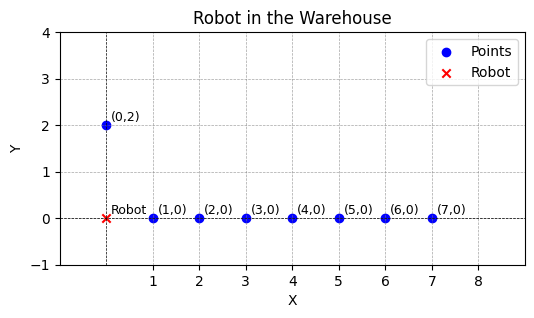

In [30]:
import matplotlib.pyplot as plt

# Coordinates
packages = [(1, 0), (2, 0), (3, 0), (4,0), (5,0), (6,0), (7, 0), (0, 2)]
x_coords, y_coords = zip(*packages)
robot = (0,0)

# Plot points
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Points')
plt.scatter(robot[0], robot[1], color='red', label='Robot', marker='x')

# Add labels to points
for x, y in packages:
    plt.text(x + 0.1, y + 0.1, f"({x},{y})", fontsize=9)
plt.text(0.1, 0.1, "Robot", fontsize=9)

# Set plot limits for better visualization
plt.xlim(-1, max(x_coords) + 2)
plt.ylim(-1, max(y_coords) + 2)

# Adjust plot
plt.gca().set_aspect('equal', adjustable='box')

# Add grid and labels
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.xticks(range(1, 9))
plt.title('Robot in the Warehouse')
plt.legend()
plt.show()


---

The following code implements the PackageCollector algorithm explained in the first three points:

In [31]:
def PackageCollector(t):
    '''
    Function that determines if a path traversing all the packages exists, and if it does, it outputs that path
    Input:
    t = number of test cases
    Output:
    None
    '''
    for _ in range(t):  # Loop over each test case
        n = int(input())  # Read the number of packages
        packages = []

        # Read packages
        for i in range(n):
            x, y = map(int, input().split())  # Read coordinates of the i-th package
            packages.append((x, y))

        packages = sorted(packages)  # Sort packages by x and y coordinates

        # Initializations
        x_current = 0  # current x-coordinate (starting at (0, 0))
        y_current = 0  # current y-coordinate (starting at (0, 0))
        path = ""  # initialize path
        possible = True  # True by default, turns False if a path is not possible

        for i in range(n):
            x, y = packages[i]

            if x < x_current or y < y_current: # check if package is reacheable
                possible = False  # cannot reach this package if it's behind in x or y
                break

            # Calculate the number of right and up moves
            num_right_moves = x - x_current
            num_up_moves = y - y_current
            
            path += 'R' * num_right_moves # Add the right moves to the path
            path += 'U' * num_up_moves # Add the up moves to the path

            # Update the current position to the current package's coordinates
            x_current = x
            y_current = y

        # Output results based on whether the path is possible
        if possible:
            print("YES")
            print(path)
        else:
            print("NO")

Below, we test the algorithm on a specific set of inputs:

3

5

1 3

1 2

3 3

5 5

4 3

2

1 0

0 1

1

4 3

In [32]:
t = int(input())  # Number of test cases
PackageCollector(t)

YES
RUUURRRRUU
NO
YES
RRRRUUU
